In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import pandas as pd
from skimage.morphology import square
from skimage.measure import label, regionprops
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from skimage.filters import threshold_otsu
import skimage.io
import skimage.filters
import skimage.measure
import os

#Show the actual image from an image matrix
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

#To read an image:
#go to the files icon on the left toolbar, press "Upload to session storage" and select the image so it is in the session
def read_image(filename):
    image = plt.imread(filename)

    
base_dir = os.path.normpath("/Users/celestecohen/Downloads")

#Make crop function
def crop(image):
    image=np.delete(image,range(950,1017),0)
    image=np.delete(image,range(0,75),0)
    image=np.delete(image,range(1400,1432),1)
    image=np.delete(image,range(0,90),1)
    return image


# 1- Creating a labeled binary for 7x7 squares

In [3]:
#Define each colony as a distinct "object"
def connected_components(filename, connectivity=2):
    # load the image
    image = skimage.io.imread(filename)
    #Crop the image
    image=crop(image)
    #blur the image
    image = skimage.filters.gaussian(image, sigma=7, truncate=8, channel_axis=True)
    # make an inverted binary
    thresh = threshold_otsu(image)
    binary = image > thresh
    binary_mask=np.invert(binary)
    #Set the minimum area of an object to 2 pixels (python was picking up 1-pixel objects when I first tried it)
    mask = skimage.morphology.remove_small_objects(binary_mask,1000)
    # perform connected component analysis (count=number of objects)
    labeled_image, count = skimage.measure.label(mask,connectivity=connectivity, return_num=True)
    regions=regionprops(labeled_image)
    return labeled_image, count, regions, mask

#labeled_image is a matrix where each object is numbered 1-96 (the background is 0)
#count is the number of objects there are (numbered 1-96 if there are 96 objects)
#regions group the individual object properties
#mask is the binary mask from which objects were found (a matrix of 1s and 0s)

In [4]:
#Find and label objects in the original JB50 7x7 plate

baseline_fname = base_dir + os.sep + "20220627_1_biofilm_JB50_7x7.jpg"
labeled_image,count,regions,mask=connected_components(baseline_fname)

#Name each object after its position (A1-H12)
def number_plate(regions):
  x_array=[]
  y_array=[]
  for r in regions:
    x,y=r["centroid"]
    x_array.append(x)
    y_array.append(y)
  rows=pd.cut(x_array,8, labels=["A","B","C","D","E","F","G","H"])
  cols=pd.cut(y_array,12, labels=["1","2","3","4","5","6","7","8","9","10","11","12"])
  index=[]
  for i in range(0,len(rows)):
    index.append(rows[i]+cols[i])
  d = {'x': x_array, 'y': y_array, "row": rows, "col":cols, "index": index}
  df = pd.DataFrame(data=d)
  return df

#Show the dataframe of x (vertical) and y (horizontal) coordinates of the centroid of each object
df=number_plate(regions)
df

,x,y,row,col,index
0,67.301153,1238.426644,A,12,A12
1,68.959430,67.807563,A,1,A1
2,68.592676,918.024454,A,9,A9
3,68.322318,1024.470146,A,10,A10
4,68.048521,1131.133776,A,11,A11
...,...,...,...,...,...
91,806.670896,814.070971,H,8,H8
92,808.022730,390.687141,H,4,H4
93,807.753544,496.342485,H,5,H5
94,809.223356,284.224777,H,3,H3


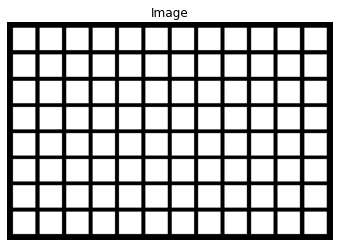

In [5]:
#Make a new binary where the centroid of each square is the average of the centroids on the side of the plate
#Eg centroid of D4 is: x=average x of D1 and D12, y=average y of A4 and H4
#Make each square in the binary 90x90 pixels

#Make a new blank mask of the same size as the image to add squares to
m=np.zeros((len(mask),len(mask[0])))

for ind in df["index"]:
  i=df[df['index']==ind].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=int(round(x-45))
  minc=int(round(y-45))
  maxr=int(round(x+45))
  maxc=int(round(y+45))
  m[minr:maxr,minc:maxc]=square(90)

show_image(m)

In [6]:
#Find and label objects in the new binary
labeled_image, count = skimage.measure.label(m,connectivity=2, return_num=True)
regions=regionprops(labeled_image)

#Return a dataframe of x and y coordinates of object centroids
df=number_plate(regions)

#Make a dictionary of each plate number
plate={}
n=0
for r in range(0,len(regions)):
  n=df.iat[r,2]+df.iat[r,3]
  plate[n]=regions[r]

# 2- Using the binary for image processing

In [7]:
#Import images
image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans" + os.sep + "20220704_biofilm_lib1" + os.sep + "20220704_1_biofilm_lib1.jpg"
image_1=np.invert(crop(skimage.io.imread(image_fname)))
image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib1_w" + os.sep + "20220704_1_biofilm_lib1_w.jpg"
image_1_w=np.invert(crop(skimage.io.imread(image_fname)))

image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib2" + os.sep + "20220704_1_biofilm_lib2.jpg"
image_2=np.invert(crop(skimage.io.imread(image_fname)))
image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib2_w" + os.sep + "20220704_1_biofilm_lib2_w.jpg"
image_2_w=np.invert(crop(skimage.io.imread(image_fname)))

image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib3" + os.sep + "20220704_1_biofilm_lib3.jpg"
image_3=np.invert(crop(skimage.io.imread(image_fname)))
image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib3_w" + os.sep + "20220704_1_biofilm_lib3_w.jpg"
image_3_w=np.invert(crop(skimage.io.imread(image_fname)))

image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib4" + os.sep + "20220704_1_biofilm_lib4.jpg"
image_4=np.invert(crop(skimage.io.imread(image_fname)))
image_fname = base_dir + os.sep + "Biofilm_bioinformatics"+os.sep+"biofilm_washing_scans"  + os.sep + "20220704_biofilm_lib4_w" + os.sep + "20220704_1_biofilm_lib4_w.jpg"
image_4_w=np.invert(crop(skimage.io.imread(image_fname)))

In [8]:
#Get the layout of the strains, make a vector of strain names in order (by row so A1, A2, etc.)
st_filename = base_dir + os.sep + "Biofilm_bioinformatics"+ os.sep + "strains.csv"
strains=pd.read_csv(st_filename,header=None)
strains=pd.DataFrame.transpose(strains)
strain_layout=[]
for i in range(0,8): #get strains in each of 8 columns
    strain_layout.extend(strains[i])
    
#Create an array of segregant names
segregants=['R' + str(ind) for ind in list(range(1,55))]

In [9]:
#Create an array of mean intensity for each square for "image" from "labeled_image"
def mean_int(image):
    mi=[]
    for i in dict.keys(plate):
        m=np.mean(image[np.where(labeled_image==plate[i]["label"])])
        mi.append(m)
    return mi

#Make a dataframe with all info for each strain and only keep segregants and B2 (759) and C2 (JB50)
def processing(image,image_w,rep):
    mean_intensities=mean_int(image)
    mean_intensities_w=mean_int(image_w)
    #Substract the mimimum mean intensity (aka just agar no yeast) from all intensities to normalise them)
    m=min(min(mean_intensities),min(mean_intensities_w))
    d = {"rep":rep,
        'position': dict.keys(plate),
         "x_coord":[plate[i]["centroid"][1] for i in dict.keys(plate)],
         "y_coord":[plate[i]["centroid"][0] for i in dict.keys(plate)],
         "strain":strain_layout,
         'before_wash': mean_intensities-m,
         "after_wash": mean_intensities_w-m
        }
    df = pd.DataFrame(data=d)
    df["ratio"]=df["after_wash"]/df["before_wash"]
    df_seg=df.loc[df['strain'].isin(segregants)]
    df_seg=pd.concat([df.loc[df['position'] == "B2"],df.loc[df['position'] == "C2"],df_seg])
    return df_seg

In [10]:
df1=processing(image_1, image_1_w, rep=1)
df2=processing(image_2, image_2_w, rep=2)
df3=processing(image_3, image_3_w, rep=3)
df4=processing(image_4, image_4_w, rep=4)

In [11]:
DF=pd.concat([df1,df2,df3,df4])
#DF.loc[DF["strain"]=="R36"]

In [12]:
import re

#Preparing phenotype data for QTL
DF_grouped=DF.groupby("strain",as_index=False).mean()
phenotype=DF_grouped[["strain","ratio"]]

#Make all segregant names R1_x
for p in range(0,len(phenotype["strain"])):
    if phenotype["strain"][p][0]=="R":
        phenotype["strain"][p]=str("R1_"+re.findall("[0-9]+",phenotype["strain"][p])[0])

#Make parental values X968 (JB50) and Y0036 (JB759)
phenotype["strain"][0]="X968"
phenotype["strain"][1]="Y0036"

#phenotype.to_csv("washing_phenotypes.csv")
#when you want to actually create the phenotypes csv file, remove the #

/var/folders/tc/jr3_rfbd30g5r7dmltld5hz80000gn/T/ipykernel_4287/3962148150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype["strain"][p]=str("R1_"+re.findall("[0-9]+",phenotype["strain"][p])[0])
/var/folders/tc/jr3_rfbd30g5r7dmltld5hz80000gn/T/ipykernel_4287/3962148150.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype["strain"][0]="X968"
/var/folders/tc/jr3_rfbd30g5r7dmltld5hz80000gn/T/ipykernel_4287/3962148150.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

## Plot 



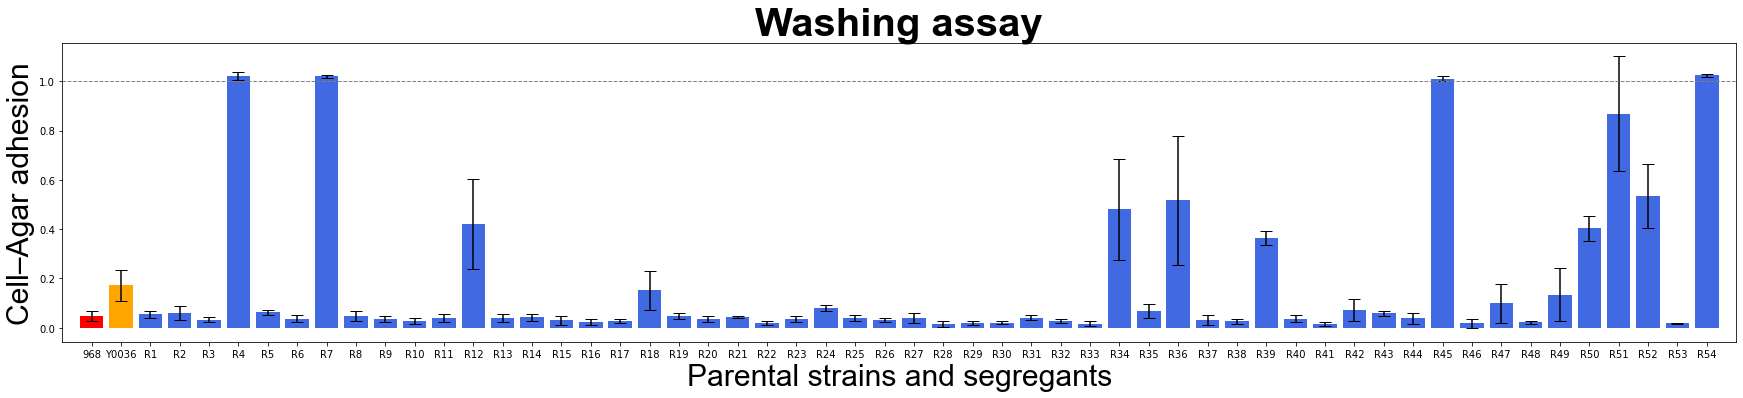

In [19]:
plt.rcParams["figure.figsize"] = (30,5.5)
fig, ax = plt.subplots()

strain_order=np.concatenate((["JB50","JB759"],segregants))

x=list(range(0,len(set(DF['strain']))))
y=[DF.loc[DF["strain"]==name] for name in strain_order]
colours=np.concatenate((["red","orange"],np.repeat("royalblue",54)))

strain_order_official=np.concatenate((["968","Y0036"],segregants))

ax.bar(x,
       height=[np.mean(yi["ratio"]) for yi in y],
       yerr=[np.std(yi["ratio"]) for yi in y],    # error bars
       capsize=6, # error bar cap width in points
       width=0.8,    # bar width,
       color=colours,
       zorder = 0,
       tick_label=strain_order_official
      )


#for i in range(len(x)):
    #ax.scatter(x[i], y[i]["ratio"], color='grey', zorder = 1)
    
ax.set_xlim(-1,56)
ax.set_ylabel('Cell–Agar adhesion',fontsize=30,fontname="Arial")
ax.set_xlabel("Parental strains and segregants",fontsize=30,fontname="Arial")
ax.set_title("Washing assay",fontsize=40,fontweight="bold",fontname="Arial")
plt.axhline(y=1, color='grey', linestyle='dashed', linewidth=1)

(0.0, 100.0)

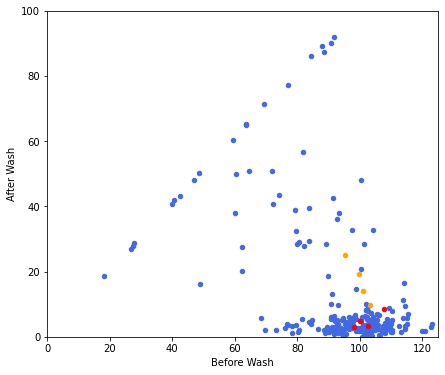

In [179]:
# Scatter plot of Raw Instensity Before and After Wash
plt.rcParams["figure.figsize"] = (7,6)
fig, ax = plt.subplots()
    
[ax.scatter(y[i]["before_wash"], y[i]["after_wash"], color=colours[i], zorder = 1,s=20) for i in range(2,56)]
[ax.scatter(y[i]["before_wash"], y[i]["after_wash"], color=colours[i], zorder = 1,s=20) for i in range(0,2)]     
        
ax.set_ylabel("After Wash")
ax.set_xlabel("Before Wash")
ax.set_xlim(0,125)
ax.set_ylim(0,100)

(0.15, 1.05)

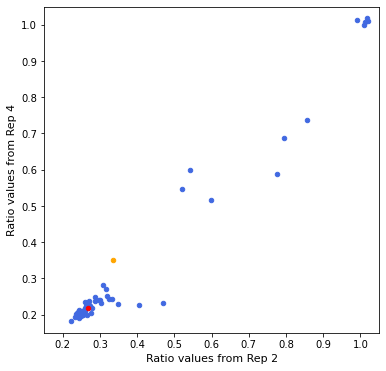

In [105]:
#Scatter plot of rep1 vs rep2
plt.rcParams["figure.figsize"] = (6,6)
fig, ax = plt.subplots()

x=list(DF.loc[DF["rep"]==2]["ratio"])
y=list(DF.loc[DF["rep"]==4]["ratio"])
[ax.scatter(x[i], y[i], color=colours[i], zorder = 1,s=20) for i in range(2,56)]
ax.scatter(x[0],y[0], color=colours[1], zorder = 1,s=20)
ax.scatter(x[1],y[1], color=colours[0], zorder = 1,s=20)

ax.set_ylabel('Ratio values from Rep 4',fontsize=11)
ax.set_xlabel("Ratio values from Rep 2",fontsize=11)
ax.set_xlim(0.15,1.05)
ax.set_ylim(0.15,1.05)

# Extra code

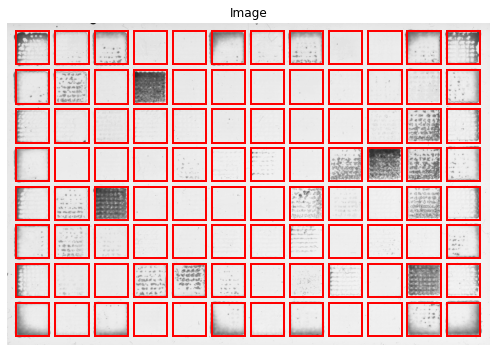

In [16]:
#This is just to show the areas coloured in the improved binary but the red squares can't actually be used as a mask
fig, ax = plt.subplots()

show_image(np.invert(image_1_w))
rect=[]
for p in plate:
  i=df[df['index']==p].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=x-45
  minc=y-45
  maxr=x+45
  maxc=y+45
  rect.append(mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2))

for r in rect:
  ax.add_patch(r)

ax.set_axis_off()
plt.tight_layout()
plt.show()

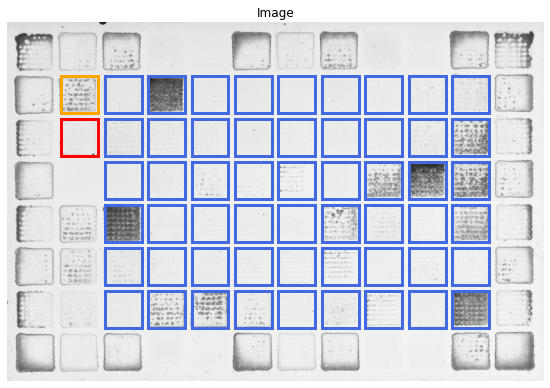

In [54]:
#this is to show the squares detected but only the ones that we want
fig, ax = plt.subplots()

show_image(np.invert(image_1_w))

rect=[]
for p in list(df1.loc[df1["strain"]=="JB50"]["position"]):
  i=df[df['index']==p].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=x-45
  minc=y-45
  maxr=x+45
  maxc=y+45
  rect.append(mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=3))

for p in list(df1.loc[df1["strain"]=="JB759"]["position"]):
  i=df[df['index']==p].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=x-45
  minc=y-45
  maxr=x+45
  maxc=y+45
  rect.append(mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='orange', linewidth=3))
   
for s in segregants:
    for p in list(df1.loc[df1["strain"]==s]["position"]):
      i=df[df['index']==p].index[0]
      r=df[df["row"]==df.iat[i,2]]
      c=df[df["col"]==df.iat[i,3]]
      x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
      y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
      minr=x-45
      minc=y-45
      maxr=x+45
      maxc=y+45
      rect.append(mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='royalblue', linewidth=3))
    
for r in rect:
  ax.add_patch(r)

ax.set_axis_off()
plt.tight_layout()
plt.show()